Repeat the factor loading correlation analysis for Factor 7:

In [1]:
server = 'mando'
if (server == 'jabba'){
    data_path = '/data3/hratch/norcross_abc/'
    gpu_use = F
}else if (server == 'mando'){
    data_path = '/data/hratch/norcross_abc/'
    gpu_use = T
}

library(reticulate, quietly = T)
if (gpu_use){
    device<-'cuda:0'
    tensorly <- reticulate::import('tensorly')
    tensorly$set_backend('pytorch')
}else{
    device<-NULL
}

n.cores<-30
env_name = 'norcross_abc'

In [2]:
suppressPackageStartupMessages({
    suppressWarnings({
        library(liana, quietly = T)
        library(decoupleR, quietly = T)
        
        library(clusterProfiler)
        
        library(Seurat, quietly = T)
        
        library(ggplot2, quietly = T)
        library(circlize, quietly = T)
        library(RColorBrewer, quietly = T)
        library(ggExtra, quietly = T)
        
        # library(textshape, quietly = T)
        c2c <- reticulate::import(module = "cell2cell", as="c2c")
        
        library(dplyr, quietly = T)
        library(tidyr, quietly = T)
        library(magrittr, quietly = T)
        library(tibble, quietly = T)
        library(reshape2, quietly = T)
        library(stringr)
        library(plyr, quietly = T)
        library(textshape, quietly = T)
    })
})

Set the pipeline parameters (things we can potentially adjust to get different outputs):

In [3]:
params<-list(return_all = FALSE, #whether to return all LRs in liana after filtering for expr_prop
             filter_specificity = FALSE, # whether to filter scores by specificty
             filter_thresh = 0.05, # specificity filter threshold
             filter_specificity_how = 'fill', # or exclude -- fill insignifanct interactions with min or remove alltogether
             lr_fill_by = NaN, # or 0 or NaN -- what to use in the lr_fill tc2c argument
             how = 'outer' # what to use in the how tc2c argument
            )

Load the data:

In [4]:
abc.integrated<-readRDS(paste0(data_path, 'processed/abc_annotated.RDS'))

Subset to the cell types and contexts of interest:

In [5]:
cell.types<-c('T-cells', 'cDC_1', 'cDC_2', 'Xcr1+ DC_1', 'Xcr1+ DC_2', 'pDC', 'ncMono', 'Mf')
contexts<-c('ABC', 'DT_ABC')
abc.ccc<-subset(abc.integrated, subset = (Cell.Type.Level1 %in% cell.types) & (Cell.Type.Level2 != 'gd-T') &
                                        (orig.ident %in% contexts))
Idents(abc.ccc)<-'Cell.Type.Level2'

Format to input to LIANA:

In [6]:
# format into sce object
DefaultAssay(abc.ccc)<-'RNA'
abc.ccc@meta.data <-abc.ccc@meta.data %>% droplevels()
abc.ccc.sce<-Seurat::as.SingleCellExperiment(abc.ccc)

In [7]:
# map LIANA consensus resource to mouse
suppressMessages({
    suppressWarnings({
        op_resource <- liana::select_resource("Consensus")[[1]]

        # Generate orthologous resource
        ortholog_resource <- liana::generate_homologs(op_resource = op_resource,
                                               target_organism = 10090) # mouse
    })
})

lr_type<-c('Cell-Cell Contact', 'ECM-Receptor', 'Secreted Signaling', NA)
names(lr_type)<-c('cell_surface_ligand', 'ecm', 'ligand', '')
# lr_cat<-factor(unname(lr_type[ortholog_resource$category_intercell_source]), 
#                                            levels = lr_type)

Load liana results from notebook 05:

In [8]:
abc.ccc.sce@metadata$liana_res<-readRDS(paste0(data_path, 'interim/', 'v2_liana_bysample.rds'))

If filtering for specificity rank, will change # of interactions in the contexts as follows:

In [9]:
sapply(abc.ccc.sce@metadata$liana_res, function(x) dim(x)[[1]])
       
if (params$filter_specificity_how == 'exclude'){
        sapply(abc.ccc.sce@metadata$liana_res, function(x) dim(x[x$specificity_rank <= params$filter_thresh, ])[[1]])
    }else if (params$filter_specificity_how == 'fill'){
        sapply(abc.ccc.sce@metadata$liana_res, function(x) dim(x[x$specificity_rank > params$filter_thresh, ])[[1]])
    }


ABC DT_ABC 
 56311  49054

ABC DT_ABC 
 45137  40384

In [10]:
if (params$filter_specificity){
    liana_res<-list()
    for (sample.name in names(abc.ccc.sce@metadata$liana_res)){
        x<-abc.ccc.sce@metadata$liana_res[[sample.name]]
        if (params$filter_specificity_how == 'exclude'){
            x<-x[x$specificity_rank <= params$filter_thresh, ] # eliminate those under threshold
        }else if (params$filter_specificity_how == 'fill'){
            x[x$specificity_rank > params$filter_thresh, 'magnitude_rank']<-max(x$magnitude_rank) # replace with "lowest" value (max because magnitude rank orders lower values as higher importance)
        }
        abc.ccc.sce@metadata$liana_res[[sample.name]]<-x
    }
}

Load TEnsor-cell2cell results:

In [11]:
abc.ccc.sce@metadata$liana_res<-liana:::preprocess_scores(context_df_dict = abc.ccc.sce@metadata$liana_res, 
                                 score_col = 'magnitude_rank', # score to preprocess
                                  outer_fraction = 1/3, # only keep cells/LRs present in atleast in 1/3 of contexts
                                                        # outer_fract shouldn't change things since there are only 3 samples
                                  invert = TRUE, # since magnitude has lower scores being more valuable
                                  invert_fun = function(x) 1-x, 
                                  non_negative = TRUE, # shouldn't effect things since all magnitude ranks are positive
                                  non_negative_fill = 0, 
                                  verbose = T
                                 )

Inverting `magnitude_rank`!

Inverting `magnitude_rank`!



In [12]:
score_col = 'magnitude_rank'

if (params$lr_fill_by == 'min'){
    lr.fill.value<-min(sapply(abc.ccc.sce@metadata$liana_res, function(x) min(x[[score_col]])))
}else if (is.numeric(params$lr_fill_by)){
    lr.fill.value<-params$lr_fill_by
}
lr.fill.value

[1] NaN

In [13]:
tensor<-reticulate::py_load_object(paste0(paste0(data_path, 'processed/', 'v2_ccc_tensor.pkl')))

In [14]:
tensor$rank

[1] 9

# Factore Correlation Analysis

In [38]:
# p.adjust = BH corrected -- # https://github.com/YuLab-SMU/clusterProfiler/issues/124
# GeneRatio -- ratio of input genes in specific pathway vs input genes in all pathways https://www.biostars.org/p/220465/

# can improve visualization by directly manipulating the @result of each output
# if doing this, change qvalueCutoff to 1 and directly filter

visualize_ora<-function(cp.out, factor.name, sig.thresh = 0.1, top_n_terms = 10){
    viz.df<-cp.out@result
    viz.df[['significant']]<-paste0('fdr > ', sig.thresh)
    viz.df[viz.df$p.adjust <= sig.thresh, 'significant']<-paste0('fdr', ' \u2264 ',  sig.thresh)

    viz.df[['significant']]<-factor(viz.df[['significant']], 
                                    levels = c(paste0('fdr', ' \u2264 ',  sig.thresh), paste0('fdr > ', sig.thresh)))
    viz.df[['log.fdr']]<- -log10(viz.df$p.adjust)
    viz.df[['GeneRatio2']]<-unlist(unname(sapply(viz.df$GeneRatio, function(x) eval(parse(text=x)))))

    viz.df<-viz.df[with(viz.df, order(significant, -GeneRatio2, -log.fdr, -Count)), ]

    viz.df<-viz.df[1:top_n_terms, ]
    viz.df[['ID']]<-factor(viz.df[['ID']], 
                                    levels = rev(viz.df[['ID']]))

    green_hex = brewer.pal(n = 11, name ='RdYlGn')[[11]]
    yellow_hex = brewer.pal(n = 11, name = 'RdYlGn')[[6]]
    red_hex = brewer.pal(n = 11, name = 'RdYlGn')[[1]]

    lower_q = min(viz.df$log.fdr[!(is.na(viz.df$log.fdr))])
    upper_q = max(viz.df$log.fdr[!(is.na(viz.df$log.fdr))])
    middle_q = mean(c(lower_q, upper_q))#median(viz.df$log.fdr[!(is.na(viz.df$log.fdr))]) 
    # middle_q = 7.5

    g<-ggplot(data = viz.df, aes(x = GeneRatio2, y = ID, color = log.fdr, size = Count, shape = significant)) + 
    geom_point() + 
    ylab('') + xlab('GeneRatio') + ggtitle(factor.name) +
#     scale_color_gradient2(low = green_hex, mid = yellow_hex, high = red_hex, name = '-log10(fdr)', 
#                          limits = c(lower_q, upper_q), midpoint = middle_q) + 
    scale_colour_gradientn(colours = rev(c("darkred", "orange", "yellow")), name = '-log10(fdr)')+
    scale_shape_manual(values = c(16,4), drop = FALSE)+
    scale_size_continuous(range = c(4,12))+
    theme_bw() + theme(#axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1), 
                      text = element_text(size = 15), plot.title = element_text(hjust = 0.5))


    return(g)
}
                                                 
visualize_ora_all<-function(ora_res, sig.thresh = 0.1, top_n_terms = 15)     {
                             
    viz.df <- data.frame(matrix(ncol = 10))
    colnames(viz.df)<-c('ID','Description','GeneRatio','BgRatio','pvalue','p.adjust','qvalue','geneID','Count', 'Comparison')

    for (comp.name in names(ora_res))({
        viz.df.sub<-ora_res[[comp.name]]@result
        viz.df.sub[['Comparison']]<-comp.name
        viz.df<-rbind(viz.df, viz.df.sub)
    })

    viz.df<-viz.df[-1,]
    rownames(viz.df)<-1:dim(viz.df)[[1]]

    viz.df[['significant']]<-paste0('fdr > ', sig.thresh)
    viz.df[viz.df$p.adjust <= sig.thresh, 'significant']<-paste0('fdr', ' \u2264 ',  sig.thresh)

    viz.df[['significant']]<-factor(viz.df[['significant']], 
                                    levels = c(paste0('fdr', ' \u2264 ',  sig.thresh), paste0('fdr > ', sig.thresh)))
    viz.df[['log.fdr']]<- -log10(viz.df$p.adjust)
    viz.df[['GeneRatio2']]<-unlist(unname(sapply(viz.df$GeneRatio, function(x) eval(parse(text=x)))))

    viz.df<-viz.df[with(viz.df, order(significant, -GeneRatio2, -log.fdr, -Count)), ]

    n_terms<-top_n_terms
    unique_n_terms<-length(unique(viz.df[1:n_terms, 'ID']))
    while ((unique_n_terms < top_n_terms) & (n_terms < dim(viz.df)[[1]])){
        n_terms <- n_terms + 1
        unique_n_terms<-length(unique(viz.df[1:n_terms, 'ID']))
    }
    viz.df<-viz.df[1:n_terms, ]

    green_hex = brewer.pal(n = 11, name ='RdYlGn')[[11]]
    yellow_hex = brewer.pal(n = 11, name = 'RdYlGn')[[6]]
    red_hex = brewer.pal(n = 11, name = 'RdYlGn')[[1]]

    lower_q = min(viz.df$log.fdr[!(is.na(viz.df$log.fdr))])
    upper_q = max(viz.df$log.fdr[!(is.na(viz.df$log.fdr))])
    middle_q = mean(c(lower_q, upper_q))#median(viz.df$log.fdr[!(is.na(viz.df$log.fdr))]) 
    # middle_q = 7.5

    g<-ggplot(data = viz.df, aes(x = Comparison, y = ID, color = log.fdr, size = GeneRatio2, shape = significant)) + 
    geom_point() + 
    ylab('') + xlab('') + ggtitle('') +
    #     scale_color_gradient2(low = green_hex, mid = yellow_hex, high = red_hex, name = '-log10(fdr)', 
    #                          limits = c(lower_q, upper_q), midpoint = middle_q) + 
    scale_colour_gradientn(colours = rev(c("darkred", "orange", "yellow")), name = '-log10(fdr)')+
    scale_shape_manual(values = c(16,4), drop = FALSE)+
    scale_size_continuous(range = c(4,12), name = 'Gene Ratio')+
    theme_bw() + theme(#axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1), 
                      text = element_text(size = 20), plot.title = element_text(hjust = 0.5))
    return(g)
}

In [34]:
organism = 'mouse' 
pathwaydb = 'GOBP' # KEGG# can't use KEGG with mouse, may want to map ortholog

# lr_pairs <- liana::select_resource('Consensus')
# lr_pairs <- lr_pairs$Consensus[c('source_genesymbol', 'target_genesymbol')]
lr_pairs <- ortholog_resource[c('source_genesymbol', 'target_genesymbol')]
names(lr_pairs) <- c('ligand', 'receptor')
lr_list <- apply(lr_pairs, 1, function(x) paste0(x[[1]], '^', x[[2]]))
lr_set <- c2c$external$generate_lr_geneset(lr_list = lr_list, 
                        complex_sep='_', # Separation symbol of the genes in the protein complex
                          lr_sep='^', # Separation symbol between a ligand and a receptor complex
                          organism=organism,
                          pathwaydb=pathwaydb,
                          readable_name=TRUE)   
                 
                 
# prep input
keys<-names(lr_set)

lr_set_R<-list()
for (key in keys){
    lr_set_R[[key]]<-reticulate::iterate(reticulate::as_iterator(lr_set[key]))
} 

ora_db<-stack(lr_set_R)
ora_db<-ora_db[c(2,1)]
names(ora_db)<-c('Pathway', 'LR_Pair')

In [35]:
# basic formatting
factors<-liana:::format_c2c_factors(tensor$factors)

# ordering categories
f.c<-factors$contexts
f.c[['context']]<-factor(f.c$context, levels(abc.ccc.sce@colData$orig.ident))
factors[['contexts']]<-f.c
for (ct in c('senders', 'receivers')){
    f.ct<-factors[[ct]]
    f.ct[['celltype']]<-factor(f.ct$celltype, levels(abc.ccc.sce@colData$Cell.Type.Level2))
    factors[[ct]]<-f.ct
}
abc.ccc.sce@metadata$tensor_res<-factors

abc.ccc.sce@colData[['group']] = abc.ccc.sce@colData[['orig.ident']] # must have a "group" for plotting

In [18]:
fos<-c('7', '8', '9')
n_lrs<-15

In [20]:
top_lrs = list()
for (factor.name in paste0('Factor ', fos)){
    top_lrs[[factor.name]] = tensor$get_top_factor_elements(order_name='interactions', 
                                factor_name=factor.name, 
                                top_number=as.integer(n_lrs))
}
top_lrs


$`Factor 7`
 Ptpn6^Cd300lf   Gnai2^P2ry12     Gnai2^Egfr   Hsp90b1^Tlr7    Lrpap1^Lrp8 
     0.1346686      0.1323831      0.1292045      0.1282974      0.1282448 
 Ptpn6^Clec12a     Fam3c^Lifr     Gnai2^Ccr5  Hsp90aa1^Egfr      Ccl5^Ccr5 
     0.1222192      0.1216240      0.1187131      0.1180992      0.1171745 
    Psap^Sort1 Hsp90aa1^Itgb3     Cd47^Sirpa       Mif^Egfr       Il16^Cd4 
     0.1164272      0.1161408      0.1155377      0.1152329      0.1140537 

$`Factor 8`
       Gnai2^Ccr5     Ptpn6^Cd300lf        Cd48^Cd244         Ccl5^Ccr5 
        0.1643898         0.1635698         0.1630565         0.1567327 
         B2m^Tfrc      Adam10^Il6ra        Hspa8^Ldlr        Copa^P2ry6 
        0.1567075         0.1393621         0.1382811         0.1325416 
       Arpc5^Ldlr Icam1^Itgax_Itgb2         Calr^Lrp1         Il16^Ccr5 
        0.1324826         0.1316305         0.1315347         0.1311606 
      Fam3c^Ffar2         Psap^Lrp1        Calr^Itgav 
        0.1299237         0.1291485         0.1290568 

$`Factor 9`
Tgfb1^Acvr1_Tgfbr1_Tgfbr2        Tgfb1^Acvr1_Tgfbr2               Gnai2^Igf1r 
                0.2195659                 0.1913889                 0.1836727 
                Arf1^Insr               Gstp1^Traf2                Gnas^Adrb2 
                0.1800842                 0.1735837                 0.1687490 
              Hspa8^Adrb2               Arpc5^Adrb2              Hsp90b1^Tlr2 
                0.1674912                 0.1651395                 0.1648572 
               Psen1^Cd44               Gnai2^Lpar3               Adam10^Cd44 
                0.1575894                 0.1557857                 0.1493177 
              Actr2^Adrb2               Tgfb1^Cxcr4                Hspa8^Ldlr 
                0.1489623                 0.1455712                 0.1431935

Let's see what differences there are at the LR resolution in Factor 7 and 8:

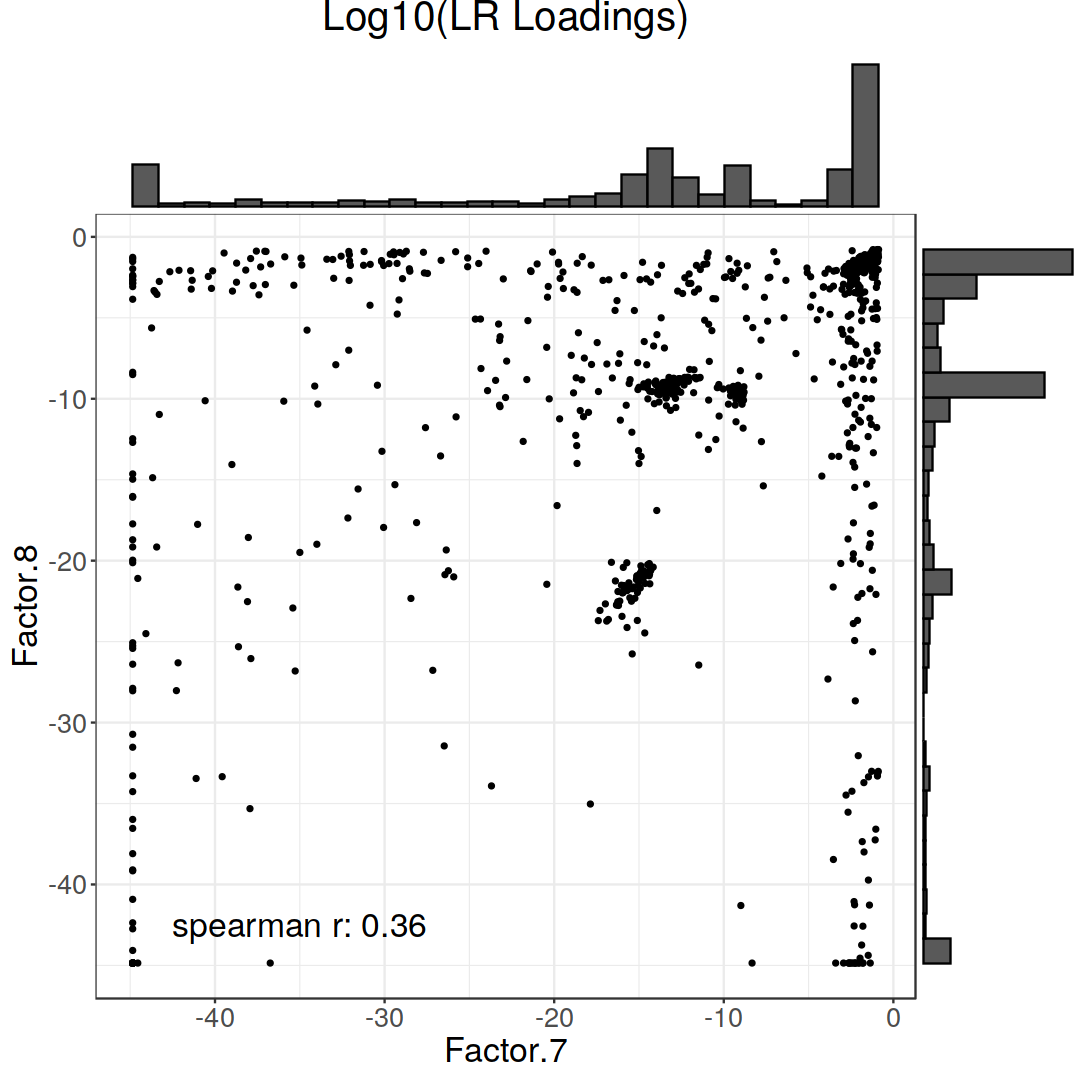

In [28]:
h_ = 9
w_ = 9
options(repr.plot.height=h_, repr.plot.width=w_)

viz.df<-factors$interactions[(c('Factor.7', 'Factor.8'))]

min_nonzero = min(viz.df[viz.df !=0]) # small psuedocount

viz.df <- log10(viz.df + min_nonzero)

spearmanr<-cor(viz.df$Factor.7, viz.df$Factor.8, method = 'spearman')
annotation <- data.frame(
   x = c(-35),
   y = c(-42.5),
   label = c((paste0('spearman r: ', format(round(spearmanr, 2), nsmall = 2))))
)

g<-ggplot(viz.df, aes(x = Factor.7, y = Factor.8)) + geom_point(size = 1, position = "jitter") + 
theme_bw() + ggtitle('Log10(LR Loadings)') + 
theme(plot.title = element_text(hjust = 0.5), text = element_text(size=20)) + 
geom_text(data=annotation, aes( x=x, y=y, label=label),
           size=7 , color = 'black')
g<-ggExtra::ggMarginal(g, type = "histogram")
g

In [29]:
viz.df[['lr']]<-factors$interactions[['lr']]
# factor9.loadings<-as.character<-viz.df[(viz.df$Factor.7 >= -10) & (viz.df$Factor.8 <= -30), 'lr']
# factor8.loadings<-as.character<-viz.df[(viz.df$Factor.8 >= -15) & (viz.df$Factor.7 <= -30), 'lr']

factor7.loadings<-as.character<-viz.df[(viz.df$Factor.7 >= -20) & (viz.df$Factor.8 <= -20), 'lr']
factor8.loadings<-as.character<-viz.df[(viz.df$Factor.8 > -20) & (viz.df$Factor.7 < -20), 'lr']

print(paste0('There are ', length(factor7.loadings), ' Factor 7 specific LRs'))
print(paste0('There are ', length(factor8.loadings), ' Factor 8 specific LRs'))

[1] "There are 121 Factor 7 specific LRs"
[1] "There are 144 Factor 8 specific LRs"


In [36]:
# run ORA on top LRs per factor
factor.list<-list(Factor.7 = factor7.loadings, Factor.8 = factor8.loadings)

ora_res<-list()
for (factor.name in names(factor.list)){
    factor_lrs <- factor.list[[factor.name]]
    if (length(setdiff(factor_lrs, lr_list)) > 0){
        stop('Unexpected LRs in loadings')
    }
    
    # if universe argument is not set, all the LRs in ora_db (which is all the LRs from the DB that mapped
    # to a pathway) will be used
    cp.out<-clusterProfiler::enricher(factor_lrs, TERM2GENE = ora_db, 
                                                     pAdjustMethod = 'BH', 
                                                      pvalueCutoff = 1, # will filter later
                                                      qvalueCutoff = 1
                                                     )
    tr = 'ADAPTIVE IMMUNE RESPONSE BASED ON SOMATIC RECOMBINATION OF IMMUNE RECEPTORS BUILT FROM IMMUNOGLOBULIN SUPERFAMILY DOMAINS'
    cp.out@result[cp.out@result$ID == tr, 'ID'] = 'ADAPTIVE IMMUNE RESPONSE (SOMATIC RECOMBINATION)'
    ora_res[[factor.name]]<-cp.out

}


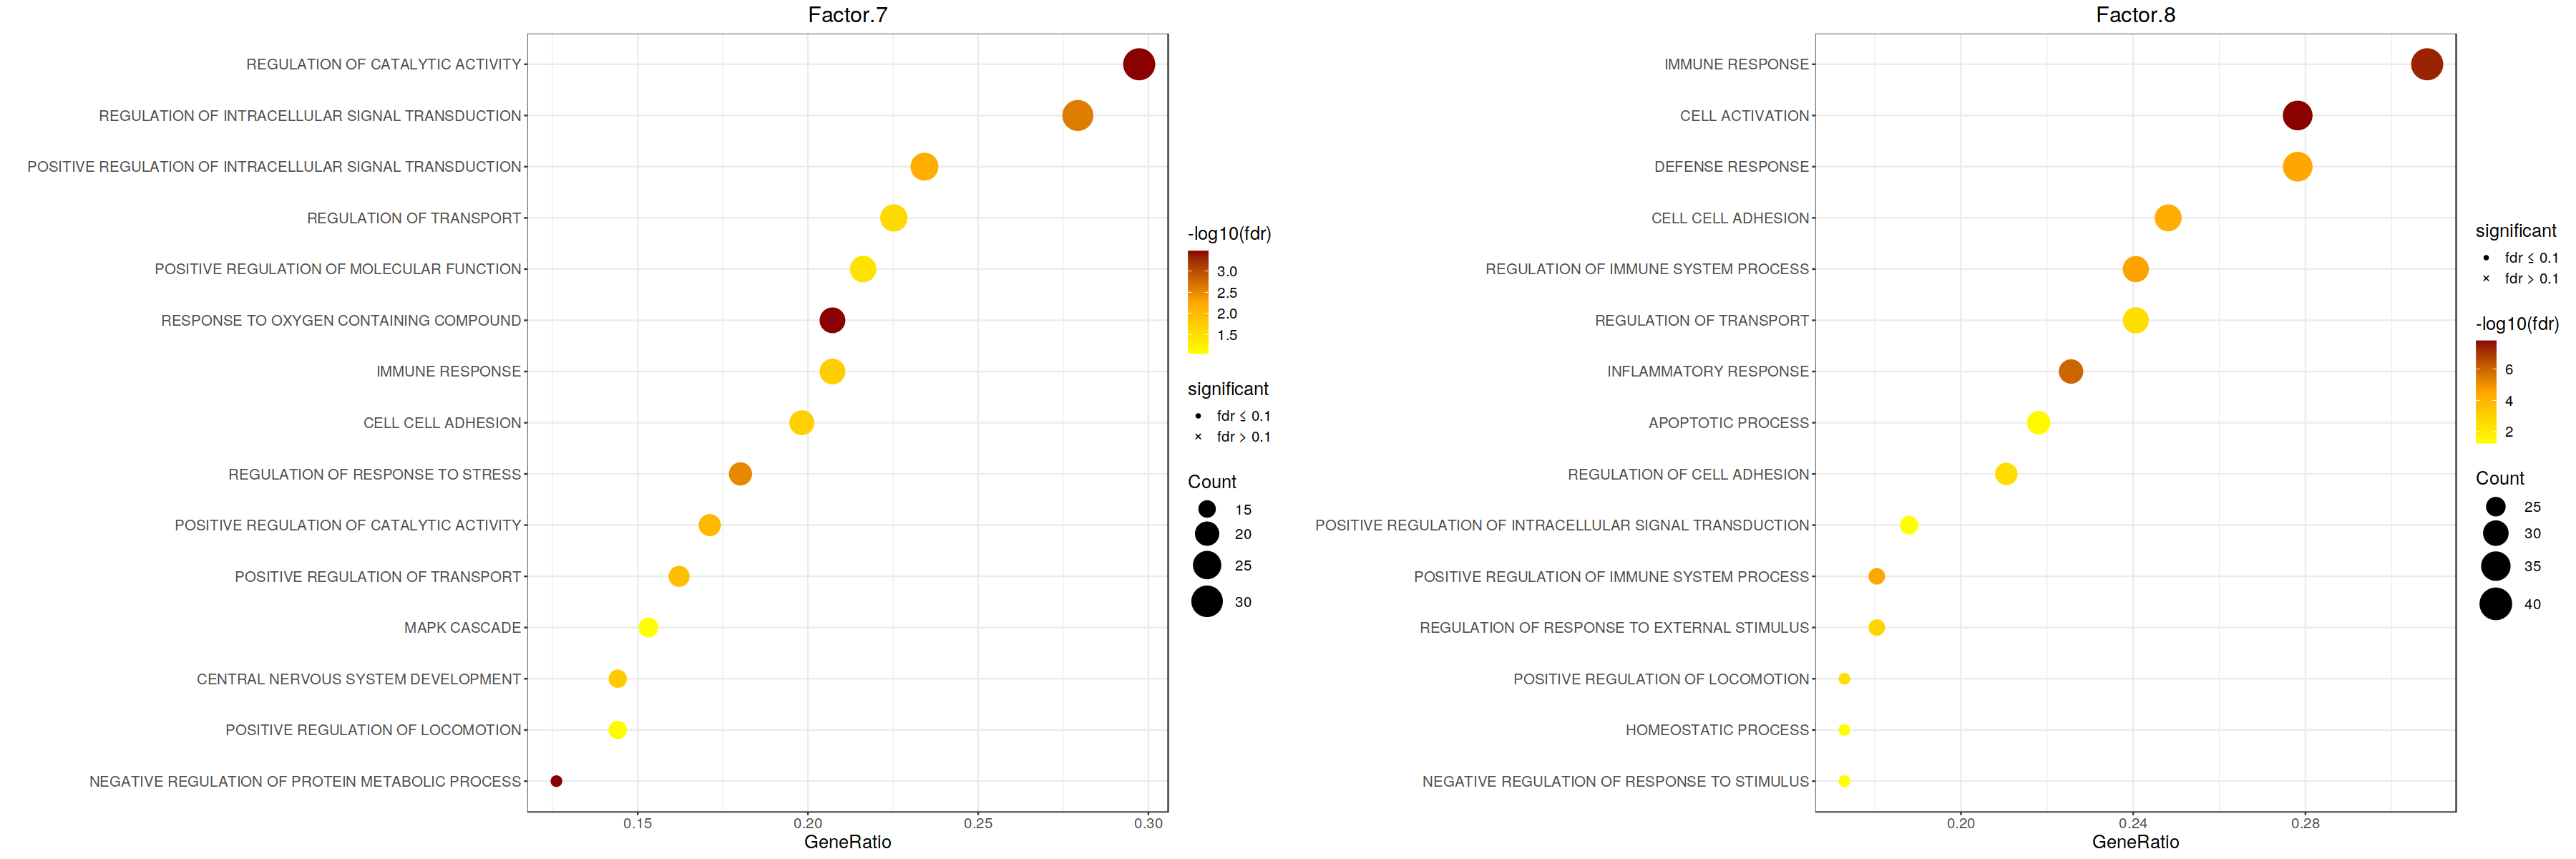

In [39]:
w_ = 30
h_ = 10
options(repr.plot.height=h_, repr.plot.width=w_)


# visualize
dotplot_list<-c()
for (fn in names(ora_res)){
    cp.out<-ora_res[[fn]]
    g<-visualize_ora(cp.out, fn, top_n_terms = 15)
    
    dotplot_list[[fn]]<-g

}

suppressWarnings({
    g<-cowplot::plot_grid(dotplot_list[[1]], dotplot_list[[2]],
                   ncol = 2)
})

g

Let's repeat this for Factor 7 and 9:

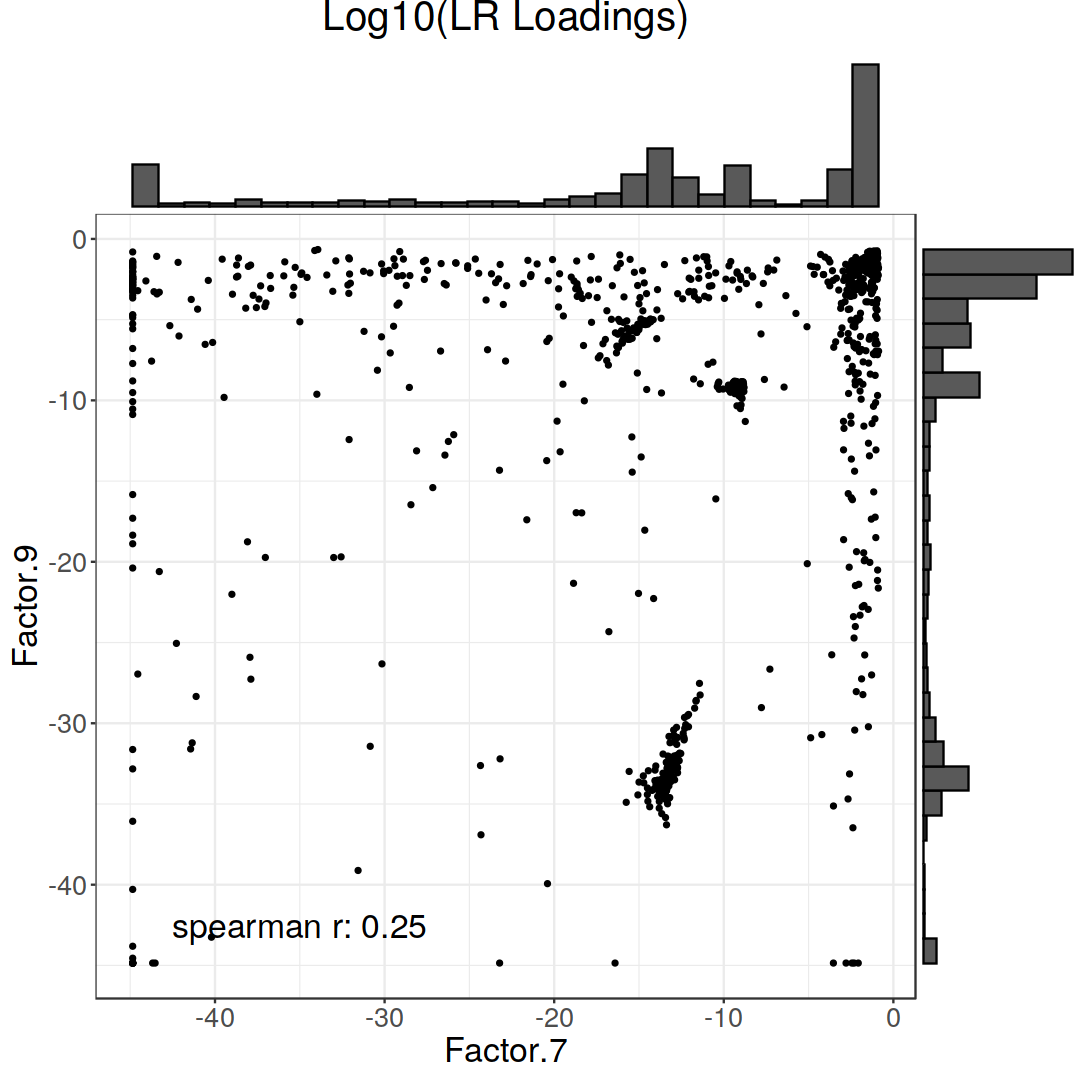

In [41]:
h_ = 9
w_ = 9
options(repr.plot.height=h_, repr.plot.width=w_)

viz.df<-factors$interactions[(c('Factor.7', 'Factor.9'))]

min_nonzero = min(viz.df[viz.df !=0]) # small psuedocount

viz.df <- log10(viz.df + min_nonzero)

spearmanr<-cor(viz.df$Factor.7, viz.df$Factor.9, method = 'spearman')
annotation <- data.frame(
   x = c(-35),
   y = c(-42.5),
   label = c((paste0('spearman r: ', format(round(spearmanr, 2), nsmall = 2))))
)

g<-ggplot(viz.df, aes(x = Factor.7, y = Factor.9)) + geom_point(size = 1, position = "jitter") + 
theme_bw() + ggtitle('Log10(LR Loadings)') + 
theme(plot.title = element_text(hjust = 0.5), text = element_text(size=20)) + 
geom_text(data=annotation, aes( x=x, y=y, label=label),
           size=7 , color = 'black')
g<-ggExtra::ggMarginal(g, type = "histogram")
g

In [43]:
viz.df[['lr']]<-factors$interactions[['lr']]
# factor9.loadings<-as.character<-viz.df[(viz.df$Factor.7 >= -10) & (viz.df$Factor.8 <= -30), 'lr']
# factor8.loadings<-as.character<-viz.df[(viz.df$Factor.8 >= -15) & (viz.df$Factor.7 <= -30), 'lr']

factor7.loadings<-as.character<-viz.df[(viz.df$Factor.7 >= -20) & (viz.df$Factor.9 <= -25), 'lr']
factor9.loadings<-as.character<-viz.df[(viz.df$Factor.9 > -20) & (viz.df$Factor.7 < -20), 'lr']

print(paste0('There are ', length(factor7.loadings), ' Factor 7 specific LRs'))
print(paste0('There are ', length(factor9.loadings), ' Factor 9 specific LRs'))

[1] "There are 164 Factor 7 specific LRs"
[1] "There are 175 Factor 9 specific LRs"


In [44]:
# run ORA on top LRs per factor
factor.list<-list(Factor.7 = factor7.loadings, Factor.9 = factor9.loadings)

ora_res<-list()
for (factor.name in names(factor.list)){
    factor_lrs <- factor.list[[factor.name]]
    if (length(setdiff(factor_lrs, lr_list)) > 0){
        stop('Unexpected LRs in loadings')
    }
    
    # if universe argument is not set, all the LRs in ora_db (which is all the LRs from the DB that mapped
    # to a pathway) will be used
    cp.out<-clusterProfiler::enricher(factor_lrs, TERM2GENE = ora_db, 
                                                     pAdjustMethod = 'BH', 
                                                      pvalueCutoff = 1, # will filter later
                                                      qvalueCutoff = 1
                                                     )
    tr = 'ADAPTIVE IMMUNE RESPONSE BASED ON SOMATIC RECOMBINATION OF IMMUNE RECEPTORS BUILT FROM IMMUNOGLOBULIN SUPERFAMILY DOMAINS'
    cp.out@result[cp.out@result$ID == tr, 'ID'] = 'ADAPTIVE IMMUNE RESPONSE (SOMATIC RECOMBINATION)'
    ora_res[[factor.name]]<-cp.out

}


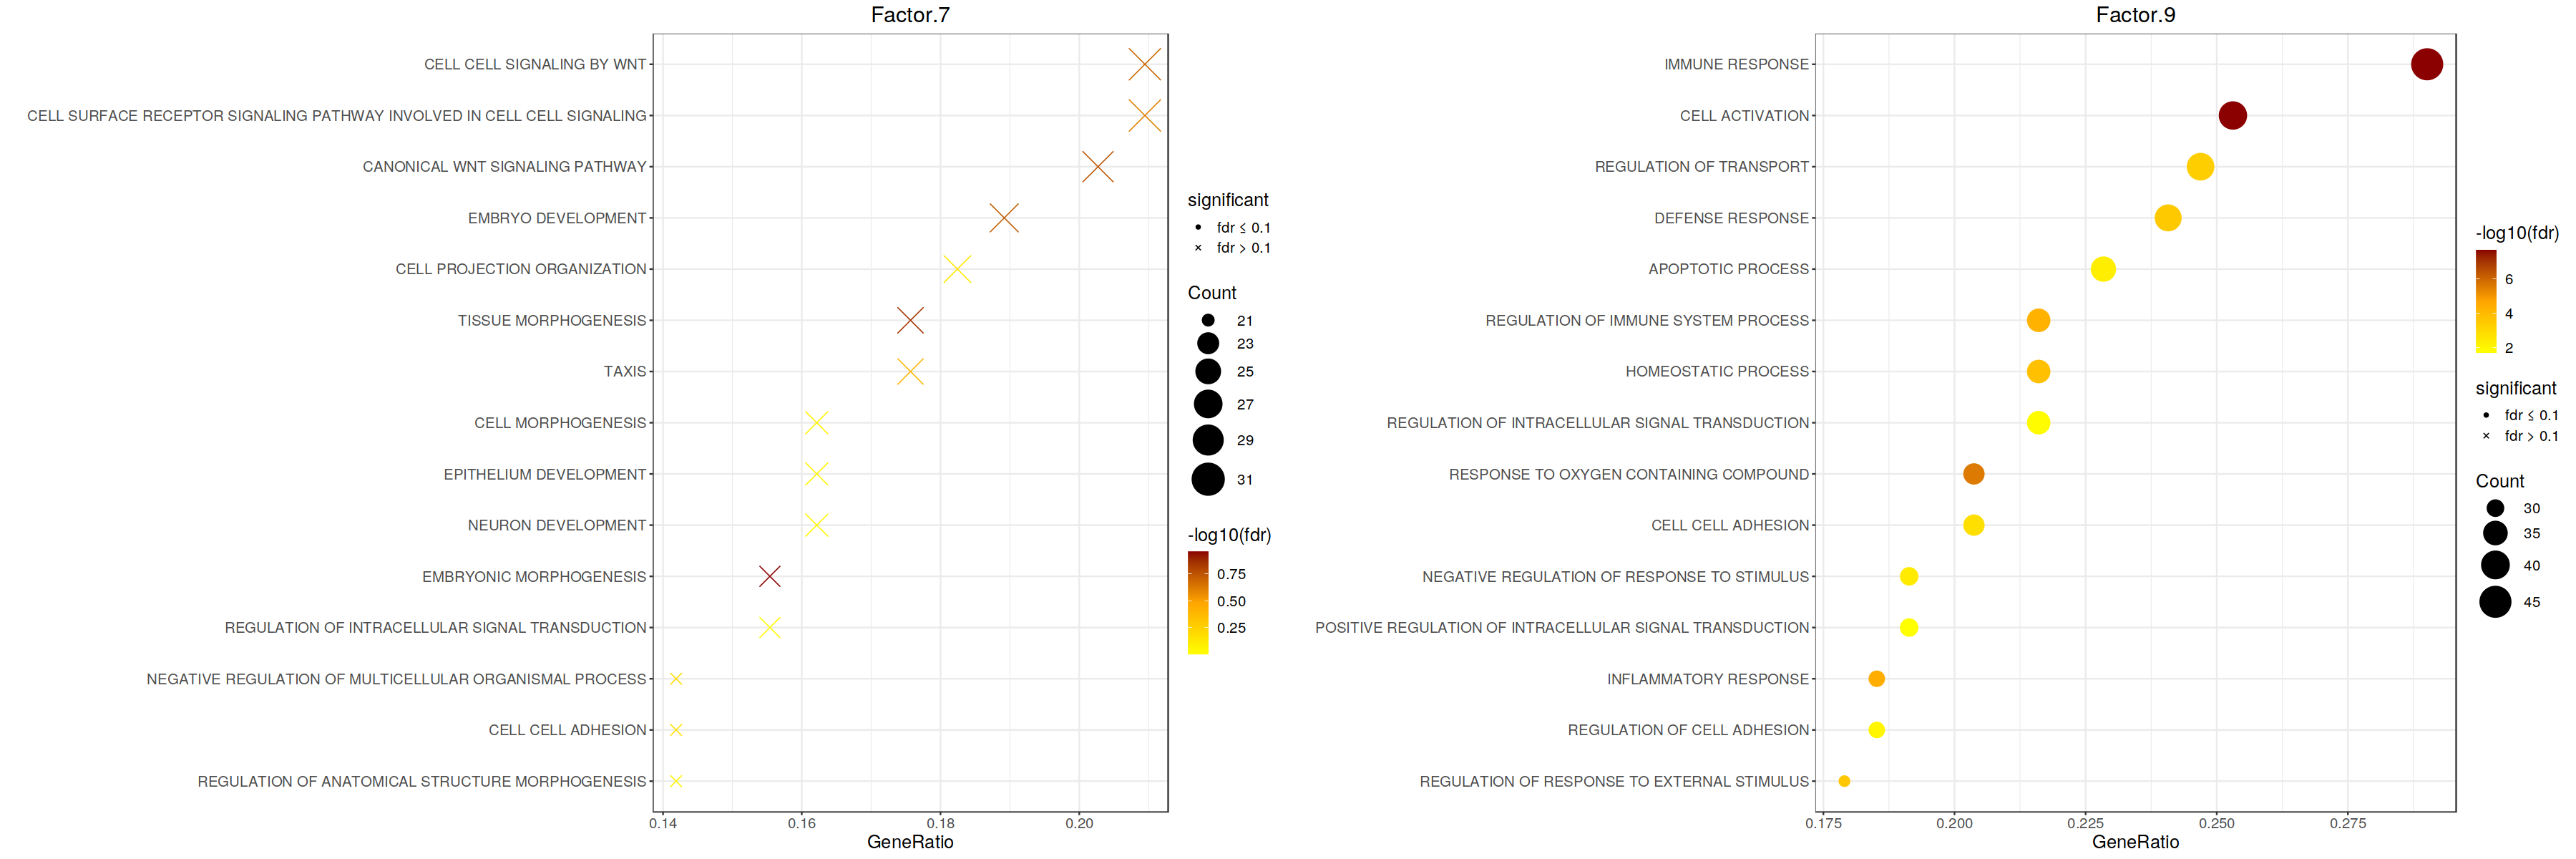

In [45]:
w_ = 30
h_ = 10
options(repr.plot.height=h_, repr.plot.width=w_)


# visualize
dotplot_list<-c()
for (fn in names(ora_res)){
    cp.out<-ora_res[[fn]]
    g<-visualize_ora(cp.out, fn, top_n_terms = 15)
    
    dotplot_list[[fn]]<-g

}

suppressWarnings({
    g<-cowplot::plot_grid(dotplot_list[[1]], dotplot_list[[2]],
                   ncol = 2)
})

g